前置操作

In [15]:
%matplotlib widget
import matplotlib.pyplot as plt
import torch
from torch import nn
from d2l import torch as d2l

class Animator:
    """用于动画化绘制数据的类"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), figsize=(4, 3)):
        self.fig, self.ax = plt.subplots(figsize=figsize)
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.legend = legend if legend is not None else []
        self.fmts = fmts
        self.X = [[] for _ in range(len(self.fmts))]
        self.Y = [[] for _ in range(len(self.fmts))]

        # 设置坐标轴属性
        self.ax.set(xlabel=xlabel, ylabel=ylabel)
        if xlim: self.ax.set_xlim(*xlim)
        if ylim: self.ax.set_ylim(*ylim)
        self.ax.set_xscale(xscale)
        self.ax.set_yscale(yscale)

    def add(self, x, y):
        """向图表中添加多个数据点"""
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n

        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)

        self.ax.clear()
        for xi, yi, fmt in zip(self.X, self.Y, self.fmts):
            self.ax.plot(xi, yi, fmt)

        if self.legend:
            self.ax.legend(self.legend)

        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()

class Accumulator:
    def __init__(self, n):
        self.data = [0, 0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0, 0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if y_hat.ndim > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = (y_hat == y)
    return cmp.sum().item()

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()

    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())

    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

模型

In [16]:
active_function = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    active_function[0],
                    nn.Linear(256,10))

def normal_weights(m):
    if isinstance(m, nn.Linear):
        # 正态分布初始化
        nn.init.normal_(m.weight, std=0.01)
        print("normal-weight:", m.weight)

def eye_weights(m):
    if isinstance(m, nn.Linear):
        # 单位矩阵
        nn.init.eye_(m.weight)
        print("eye-weight:", m.weight)

def uniform_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight,a=-1, b=1)
        print("uniform-weight:", m.weight)

训练函数

In [17]:
def train(index):
    if index == 0:
        net.apply(normal_weights)
    elif index == 1:
        net.apply(eye_weights)
    else:
        net.apply(uniform_weights)

    batch_size, lr, num_epochs = 256, 0.1, 10
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=lr)

    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

进行训练

normal-weight: Parameter containing:
tensor([[-0.0009,  0.0008, -0.0077,  ..., -0.0075, -0.0037,  0.0054],
        [ 0.0064,  0.0087, -0.0016,  ..., -0.0034,  0.0090,  0.0162],
        [-0.0104,  0.0004, -0.0021,  ..., -0.0023, -0.0022,  0.0043],
        ...,
        [ 0.0040, -0.0125,  0.0065,  ..., -0.0066,  0.0071,  0.0115],
        [ 0.0314, -0.0223,  0.0074,  ...,  0.0062, -0.0071, -0.0062],
        [-0.0060, -0.0180,  0.0027,  ...,  0.0042,  0.0056,  0.0079]],
       requires_grad=True)
normal-weight: Parameter containing:
tensor([[ 0.0032,  0.0005,  0.0016,  ..., -0.0069,  0.0024,  0.0083],
        [ 0.0082, -0.0130, -0.0038,  ...,  0.0039, -0.0059, -0.0042],
        [-0.0079, -0.0005,  0.0005,  ..., -0.0103,  0.0008, -0.0051],
        ...,
        [ 0.0051, -0.0129, -0.0011,  ...,  0.0006, -0.0164,  0.0039],
        [-0.0047,  0.0005, -0.0139,  ..., -0.0099,  0.0111, -0.0029],
        [ 0.0110,  0.0112, -0.0134,  ..., -0.0035, -0.0025,  0.0124]],
       requires_grad=True)


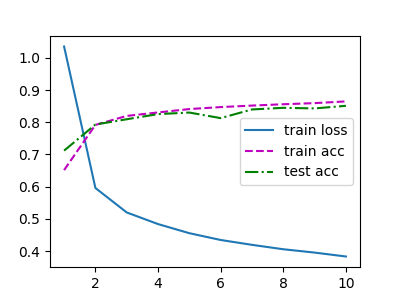

In [18]:
train(0)

eye-weight: Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
eye-weight: Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)


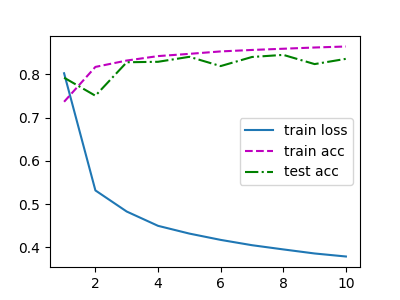

In [19]:
train(1)

uniform-weight: Parameter containing:
tensor([[ 1.9284e-01, -1.3162e-01, -6.9548e-01,  ...,  7.2261e-01,
         -3.1647e-02, -2.0405e-01],
        [-9.6349e-01,  9.8626e-01,  3.5801e-01,  ...,  2.2656e-01,
         -8.0973e-01, -8.0868e-01],
        [-7.1185e-01, -4.1232e-01,  6.8590e-01,  ..., -4.8764e-01,
          2.7443e-01, -9.8226e-01],
        ...,
        [ 1.1964e-01,  9.5697e-01, -5.0872e-01,  ..., -1.7691e-01,
          6.4788e-01,  8.8855e-01],
        [-5.8476e-02, -8.6515e-01, -2.2091e-02,  ...,  7.7508e-01,
         -1.9476e-01,  7.5054e-04],
        [-7.2045e-01,  7.1223e-01,  6.3691e-01,  ...,  7.4598e-01,
          8.5762e-01,  7.2688e-01]], requires_grad=True)
uniform-weight: Parameter containing:
tensor([[-0.6532, -0.9584,  0.2194,  ..., -0.5681,  0.4295, -0.7465],
        [-0.3778,  0.3135, -0.0573,  ..., -0.0799,  0.0311, -0.4049],
        [-0.2182,  0.4565,  0.0843,  ...,  0.9642, -0.1951,  0.0060],
        ...,
        [-0.7275,  0.1255,  0.4491,  ...,  0.3767

AssertionError: 0.5065633834838867

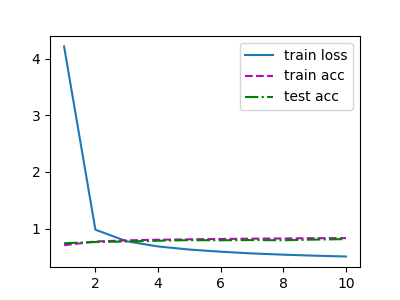

In [20]:
train(2)